In [1]:
import onnxruntime as ort
import numpy as np
import cv2
from PIL import Image

from matplotlib import pyplot as plt

In [2]:
# params
MODEL = "../remx/runs/detect/train/weights/best.onnx"
PROTOTXT = 'remx.prototxt'
IMAGE = './test-elephant.jpg'


In [3]:
ort_session = ort.InferenceSession(MODEL)

model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape
input_shape

[1, 3, 640, 640]

In [4]:
model_output = ort_session.get_outputs()
output_names = [model_output[i].name for i in range(len(model_output))]
output_names

['output0']

In [5]:
# Preprocess image
import sys
sys.path.append("../remx/utils")

from images import letterbox, ImgSize, inverse_letterbox_coordinate_transform

img = cv2.imread(IMAGE)
img_letterboxed = letterbox(np.asarray(img), ImgSize(640, 640))

cv2.imwrite("test-elephant-letterboxed.jpg", img_letterboxed)

True

In [6]:
letterboxed_image = "./test-elephant-letterboxed.jpg"

image = cv2.imread(letterboxed_image)
image_height, image_width = image.shape[:2]

Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
input_height, input_width = input_shape[2:]

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized = cv2.resize(image_rgb, (input_width, input_height))

# Scale input pixel value to 0 to 1
input_image = resized / 255.0
input_image = input_image.transpose(2,0,1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)
input_tensor.shape

(1, 3, 640, 640)

In [7]:
outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]

In [8]:
# Threshold
predictions = np.squeeze(outputs).T
conf_thresold = 0.85 # confidence score still testing in phase

# Filter out object confidence scores below threshold
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > conf_thresold, :]
scores = scores[scores > conf_thresold]

In [9]:
# Get the class with the highest confidence
class_ids = np.argmax(predictions[:, 4:], axis=1)
class_ids

array([1])

In [10]:
# Get bounding boxes for each object
boxes = predictions[:, :4]

#rescale box
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float32)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)
boxes

array([[365, 350, 336, 239]], dtype=int32)

In [11]:
# TODO(Adam-Al-Rahman): Optimize the compute_iou function
def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou

In [12]:

# TODO(Adam-Al-Rahman): Optimize the nms function
def nms(boxes, scores, iou_threshold):
    """
    Non-maximum suppression (NMS)
    Select best bounding box out of a set of overlapping boxes.
    """

    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes

In [13]:
# Apply non-maxima suppression to suppress weak, overlapping bounding boxes
indices = nms(boxes, scores, 0.3)

In [14]:
def xywh2xyxy(x):
    """
    yolov8 provide bounding box (x, y, w, h).
    Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    """
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

In [15]:
# TODO(Adam-Al-Rahman): Implement the remx.prototxt, and read the class from prototxt
# Define classes
CLASSES = ['axis-deer', 'elephant']

letterboxed_boxes = []
labels = []

image_draw = image.copy()
for (bbox, score, label) in zip(xywh2xyxy(boxes[indices]), scores[indices], class_ids[indices]):
    bbox = bbox.round().astype(np.int32).tolist()
    letterboxed_boxes.append(tuple(bbox))
    labels.append(CLASSES[label])

    print(bbox)
    print(score)
    print(label)
    print("----------")

    cls_id = int(label)
    cls = CLASSES[cls_id]
    box_color = (0, 255, 0)

    cv2.rectangle(image_draw, tuple(bbox[:2]), tuple(bbox[2:]), box_color, 2)
    cv2.putText(image_draw,
        f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1.0,
        color=(0, 0, 0),
        thickness=2)

    # TODO(Adam-Al-Rahman): Check the re-apperance of multiple box for same object @ same location
    # break

[197, 230, 533, 469]
0.8819891
1
----------


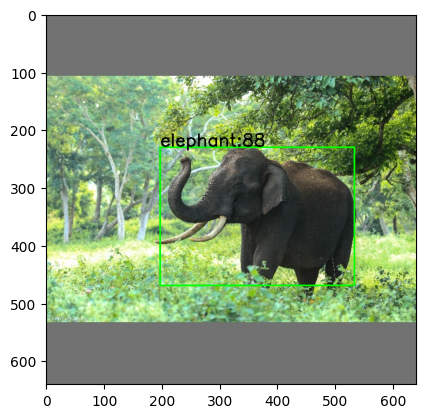

In [16]:

%matplotlib inline

img = cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
plt.imshow(img)
plt.show()


In [17]:
# original image
img = cv2.imread(IMAGE)

inverse_coordinates = inverse_letterbox_coordinate_transform(
    # [(x1, y1, x2, y2)]
    letterboxed_boxes,
    ImgSize(img.shape[1], img.shape[0]),
    ImgSize(640, 640),
)

In [18]:
# BBox coordinate for original image and its label
inverse_coordinates, labels

([(1684, 1054, 4557, 3098)], ['elephant'])

In [ ]:
# TODO(Adam-Al-Rahman): Implement the result.csv
# import csv

# with open("../models/results.csv", 'w', newline='') as file:
#   writer = csv.writer(file)


In [19]:

bbox = []

for box in inverse_coordinates:
  bbox.append(list(box))

for (bbox, score, label) in zip(bbox, scores[indices], class_ids[indices]):
  print(bbox)
  print(score)
  print(label)
  print("----------")

  cls_id = int(label)
  cls = CLASSES[cls_id]
  box_color = (255, 0, 255)

  cv2.rectangle(img, tuple(bbox[:2]), tuple(bbox[2:]), box_color, 10)
  cv2.putText(img,
      f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
      fontScale=7.0,
      color=(0, 0, 0),
      thickness=10)


[1684, 1054, 4557, 3098]
0.8819891
1
----------


<function matplotlib.pyplot.show(close=None, block=None)>

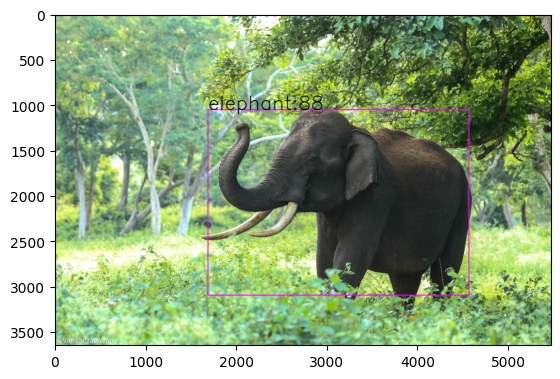

In [20]:
# Display the letterboxed image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show